In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
import numpy as np
import os
from IPython.core.debugger import set_trace
import pandas as pd

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

In [21]:
hm = 6
window_dim = hm/2/4

velocity_scaling = 1
ventilation_scaling = velocity_scaling/(window_dim**2)

norm_vel = probePost.quick_dict_apply(lambda data_df: data_df*velocity_scaling)
norm_vent = probePost.quick_dict_apply(
    lambda data_df: data_df*velocity_scaling)
abs_values = probePost.quick_dict_apply(lambda df: df.abs())
norm_data = lambda data_df : data_df*ventilation_scaling
flip_data = probePost.quick_dict_apply(lambda data_df: -data_df)


In [22]:
run = 14
qois = ["rho"]

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qois)


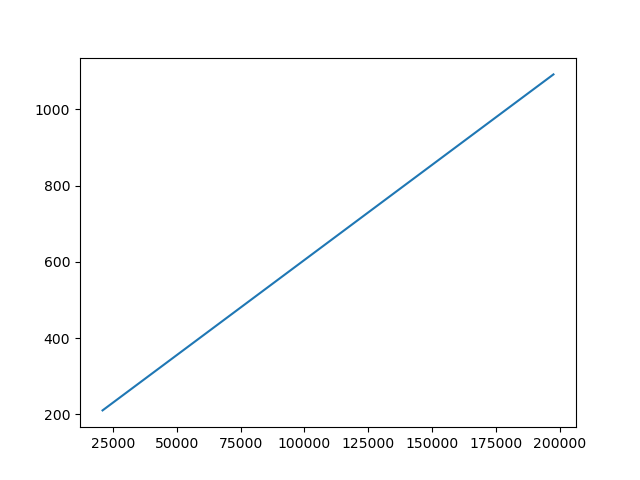

In [23]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [25]:
start = 1
stop = -2
by = 1

## X Flow


In [28]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, norm_norm],
    parrallel=True
    )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )


display(x_mean)
display(x_rms)
display(x_net)

processing data took 4 seconds


In [51]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')

x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_69499/2225782678.py:1: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')


NameError: name 'x_mean' is not defined

## Z Flow


In [16]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['zwindow_0-1', 'zwindow_1-1', 'zwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, probePost.linear_quadrature],
    parrallel=True
    )

## mean statistics
z_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_average, norm_norm],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.linear_quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(z_mean)
display(z_rms)
display(z_net)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/opt/homebrew/Caskroom/miniconda/base/envs/pycascade/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/pycascade/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyError: ('zwindow_0-0_h_3-0', 'comp(u,2)')

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows')

z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

/tmp/ipykernel_15423/257389554.py:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows')


## Y Flow


processing data took 21 seconds
processing data took 21 seconds
processing data took 20 seconds
processing data took 20 seconds


,"comp(u,2)"
skylight_0-0_skylights,0.011895
skylight_0-1_skylights,0.020635
skylight_1-0_skylights,-0.055098
skylight_1-1_skylights,0.072624
skylight_2-0_skylights,-0.081533
skylight_2-1_skylights,0.071676


,"comp(u,2)"
skylight_0-0_skylights,0.041424
skylight_0-1_skylights,0.032390
skylight_1-0_skylights,0.021440
skylight_1-1_skylights,0.039562
skylight_2-0_skylights,0.018559
skylight_2-1_skylights,0.017888


,"comp(u,0)"
skylight_0-0_skylights,0.037887
skylight_0-1_skylights,0.107428
skylight_1-0_skylights,0.024180
skylight_1-1_skylights,0.022679
skylight_2-0_skylights,0.026284
skylight_2-1_skylights,0.020221


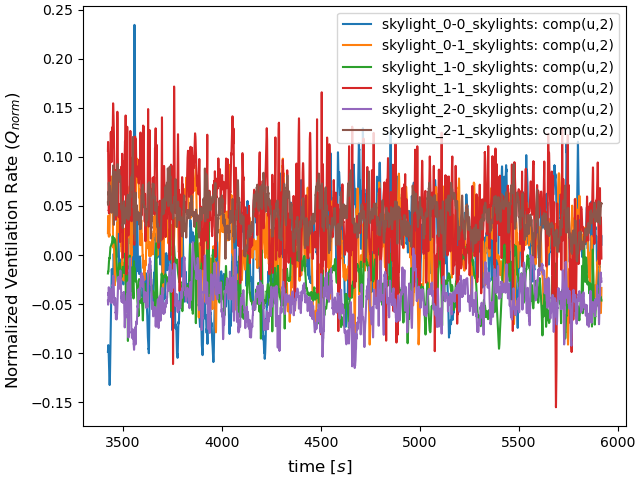

In [ ]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, probePost.linear_quadrature],
    parrallel=True
    )

## mean statistics
y_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.linear_quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(y_mean)
display(y_rms)
display(y_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')